In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix, classification_report

In [105]:
# Veriyi yükleyin
df = pd.read_csv('C:/Users/lenovo/Desktop/verianalizi/users_errors.csv')

In [106]:
# Hata kontrolü: 'interaction_time' sütunu varsa datetime formatına çevir
if 'interaction_time' in df.columns:
    df['interaction_time'] = pd.to_datetime(df['interaction_time'], errors='coerce')
    df['interaction_time'] = df['interaction_time'].fillna(pd.Timestamp.now())

# Label Encoding (Kategorik verileri sayısala çevir)
label_encoder = LabelEncoder()
categorical_columns = ['interaction_type', 'interaction_details', 'device_id', 'ip_address', 'location']

for col in categorical_columns:
    if col in df.columns:
        df[col] = label_encoder.fit_transform(df[col].astype(str))  # Hata almamak için string'e çevir

# Özellikleri ölçeklendirme (Modelin daha iyi çalışması için)
scaler = StandardScaler()
scaled_features = ['interaction_type', 'interaction_details', 'device_id', 'ip_address', 'location']

df[scaled_features] = scaler.fit_transform(df[scaled_features])

# **Anomali Tespiti İçin Hedef Değişkeni Oluşturma**
# 'Invalid Input' ve 'Authentication Failed' içeren etkileşimleri anomali olarak işaretle
df['is_anomaly'] = 0  # Varsayılan olarak tüm verileri normal kabul et


In [107]:
if 'interaction_type' in df.columns:
    invalid_labels = ['Invalid Input', 'Authentication Failed']
    for label in invalid_labels:
        if label in label_encoder.classes_:
            label_encoded = label_encoder.transform([label])[0]
            df.loc[df['interaction_type'] == label_encoded, 'is_anomaly'] = 1

# Bağımsız ve bağımlı değişkenleri ayır
X = df.drop(columns=['is_anomaly'])
y = df['is_anomaly']

# **Isolation Forest Modeli**
iso_forest = IsolationForest(n_estimators=100, contamination=0.02, random_state=42)

try:
    y_pred_if = iso_forest.fit_predict(X)
    y_pred_if = np.where(y_pred_if == -1, 1, 0)  # -1 olanları 1 (anomali), diğerlerini 0 yap
except Exception as e:
    print("Isolation Forest modeli çalıştırılırken hata oluştu:", e)
    y_pred_if = np.zeros(len(y))  # Model başarısız olursa varsayılan olarak 0 ver
# **Local Outlier Factor (LOF) Modeli**
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.02)


Isolation Forest modeli çalıştırılırken hata oluştu: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>)


Isolation Forest modeli çalıştırılırken hata oluştu: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Int64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.Float64DType'>, <class 'numpy.dtypes.DateTime64DType'>)
Local Outlier Factor modeli çalıştırılırken hata oluştu: The DType <class 'numpy.dtypes.DateTime64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.Int64DTy

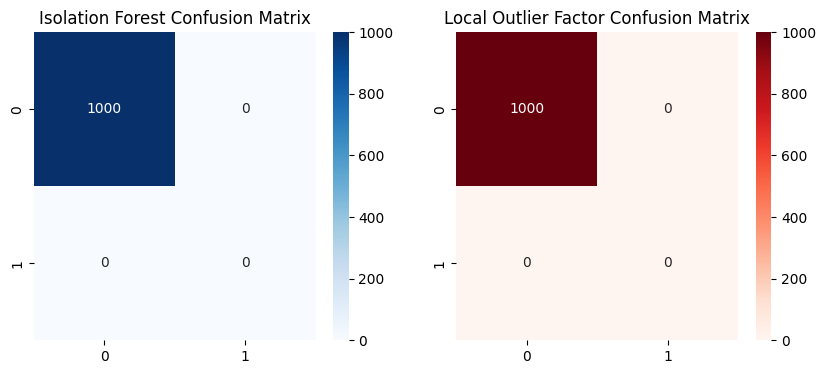

In [111]:
# **Isolation Forest Modeli**
try:
    y_pred_if = iso_forest.fit_predict(X)
    y_pred_if = np.where(y_pred_if == -1, 1, 0)  # -1 olanları 1 (anomali), diğerlerini 0 yap
except Exception as e:
    print("Isolation Forest modeli çalıştırılırken hata oluştu:", e)
    y_pred_if = np.zeros(len(y))  # Model başarısız olursa varsayılan olarak 0 ver

# **Local Outlier Factor (LOF) Modeli**
try:
    y_pred_lof = lof.fit_predict(X)
    y_pred_lof = np.where(y_pred_lof == -1, 1, 0)
except Exception as e:
    print("Local Outlier Factor modeli çalıştırılırken hata oluştu:", e)
    y_pred_lof = np.zeros(len(y))  # Model başarısız olursa varsayılan olarak 0 ver

# **Confusion Matrix ve Classification Report**
print("Isolation Forest - Classification Report:\n", classification_report(y, y_pred_if, zero_division=1))
print("Local Outlier Factor - Classification Report:\n", classification_report(y, y_pred_lof, zero_division=1))

# **Confusion Matrix Çizimi**
labels = [0, 1]  # Olası etiketler
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y, y_pred_if, labels=labels), annot=True, fmt="d", cmap="Blues")
plt.title("Isolation Forest Confusion Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y, y_pred_lof, labels=labels), annot=True, fmt="d", cmap="Reds")
plt.title("Local Outlier Factor Confusion Matrix")

plt.show()